In [1]:
import pathlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
def model_stats_grab(
    predicted_df: pd.DataFrame,
    actual_df: pd.DataFrame,
) -> tuple:
    """
    Calculate model statistics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2) from predicted and actual values.

        Parameters
        ----------
        predicted_df : pd.DataFrame
            DataFrame containing the predicted values.
        actual_df : pd.DataFrame
            DataFrame containing the actual values.

        Returns
        -------
        tuple
        mse : float
            Mean Squared Error between predicted and actual values.
        mae : float
            Mean Absolute Error between predicted and actual values.
        r2 : float
            R-squared value indicating the proportion of variance explained by the model.
    """

    assert (
        predicted_df.shape == actual_df.shape
    ), "Predicted and actual DataFrames must have the same shape."
    # if predicted_df.isinstance(pd.DataFrame):
    #     predicted = predicted_df.values
    # if isinstance(predicted_df, pd.Series):
    #     actual = actual_df.values

    mse = mean_squared_error(actual_df, predicted_df)
    mae = mean_absolute_error(actual_df, predicted_df)
    r2 = r2_score(actual_df, predicted_df)

    return mse, mae, r2

In [3]:
# load the training data
profile_file_dir = pathlib.Path("../data_splits/test.parquet").resolve(strict=True)

models_path = pathlib.Path("../models").resolve(strict=True)

terminal_column_names = pathlib.Path("../results/terminal_columns.txt").resolve(
    strict=True
)
predictions_save_path = pathlib.Path("../results/model_performances.parquet").resolve()
terminal_column_names = [
    line.strip() for line in terminal_column_names.read_text().splitlines()
]
results_dir = pathlib.Path("../results/").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

profile_df = pd.read_parquet(profile_file_dir)
print(profile_df.shape)
profile_df.head()

(10, 2858)


,Metadata_Well,Metadata_dose,Metadata_number_of_singlecells,Metadata_apoptosis_ground_truth,Metadata_plate,Metadata_compound,Metadata_control,Cells_AreaShape_Compactness_CP,Cells_AreaShape_Eccentricity_CP,Cells_AreaShape_Extent_CP,...,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_00_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_01_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_02_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_03_256,Terminal_Nuclei_Texture_Correlation_DNA_3_02_256,Terminal_Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Terminal_Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Terminal_Nuclei_Texture_SumAverage_DNA_3_01_256
0,C-03,0.61,179.0,negative,1,Staurosporine,test,0.119876,0.391440,-0.130041,...,-0.808012,-0.654050,-0.832951,-0.666071,0.643979,-0.666506,0.176932,0.474450,-0.020130,0.347586
1,C-08,19.53,153.0,positive,1,Staurosporine,test,0.640707,0.531859,-0.847293,...,-0.365226,-0.500782,-0.363246,-0.662698,0.643979,-0.412829,0.375960,0.474450,0.000188,0.347586
2,C-09,39.06,169.0,positive,1,Staurosporine,positive,-0.014601,0.305672,-0.619250,...,-0.309781,-0.543980,-0.191513,-0.420319,-0.688775,0.144592,0.567955,0.097852,0.085920,0.913750
3,C-10,78.13,169.0,positive,1,Staurosporine,test,-0.332430,0.276012,-0.479134,...,-0.165810,-0.309597,0.022089,-0.363412,-0.660509,-0.072868,0.513186,-0.229639,0.136656,2.237520
4,D-02,0.00,162.0,control,1,Staurosporine,negative,-0.025938,0.474477,0.015773,...,-0.384292,-0.524883,-0.366365,-0.541129,0.643979,0.012450,0.558280,0.474450,0.009871,0.347586


In [4]:
single_feature = "Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV"

In [5]:
terminal_df = profile_df[terminal_column_names]
single_feature_df = profile_df[[single_feature]]
profile_df = profile_df.drop(columns=terminal_column_names)

In [6]:
models = pathlib.Path(models_path).glob("*.joblib")
models_dict = {
    "model_name": [],
    "model_path": [],
    "shuffled": [],
    "feature": [],
}

for model_path in models:
    models_dict["model_name"].append(model_path.name)
    models_dict["model_path"].append(model_path)
    models_dict["shuffled"].append(
        "shuffled" if "shuffled" in model_path.name else "not_shuffled"
    )
    models_dict["feature"].append(
        "Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV"
        if "terminal_feature" in model_path.name
        else "all_terminal_features"
    )

In [7]:
results_dict = {
    "model_name": [],
    "shuffled": [],
    "feature": [],
    "mse": [],
    "mae": [],
    "r2": [],
}

In [8]:
metadata_columns = [x for x in profile_df.columns if "metadata" in x.lower()]
terminal_column_names = [x for x in profile_df.columns if "Terminal" in x]
features_df = profile_df.drop(columns=metadata_columns, errors="ignore")

In [9]:
models_dict

{'model_name': ['train_shuffled_elastic_net_single_terminal_features_model_shuffled.joblib',
  'train_elastic_net_single_terminal_features_model.joblib',
  'train_shuffled_elastic_net_all_annexinv_features_model_shuffled.joblib',
  'train_elastic_net_all_annexinv_features_model.joblib'],
 'model_path': [PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/5.bulk_timelapse_model/models/train_shuffled_elastic_net_single_terminal_features_model_shuffled.joblib'),
  PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/5.bulk_timelapse_model/models/train_elastic_net_single_terminal_features_model.joblib'),
  PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/5.bulk_timelapse_model/models/train_shuffled_elastic_net_all_annexinv_features_model_shuffled.joblib'),
  PosixPath('/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/5.bulk_timelapse_model/models/train_elastic_net_all_annexinv_features_model.joblib')],
 'shuffled': ['shu

In [10]:
for i, model_name in enumerate(models_dict["model_name"]):
    print(f"Processing model {i + 1}/{len(models_dict['model_name'])}: {model_name}")
    print(models_dict["feature"][i])
    model = joblib.load(models_dict["model_path"][i])
    if "all_terminal_features" not in str(models_dict["feature"][i]):
        predictions = model.predict(features_df[model.feature_names_in_])
        print(predictions.shape, single_feature_df[single_feature].shape)

        mse, mae, r2 = model_stats_grab(predictions, single_feature_df[single_feature])
        results_dict["shuffled"].append(models_dict["shuffled"][i])
        results_dict["feature"].append(models_dict["feature"][i])
    else:
        predictions = model.predict(features_df[model.feature_names_in_])
        print(predictions.shape, terminal_df.shape)
        mse, mae, r2 = model_stats_grab(predictions, terminal_df)
        results_dict["shuffled"].append(models_dict["shuffled"][i])
        results_dict["feature"].append("all_terminal_features")

    results_dict["model_name"].append(model_name)
    results_dict["mse"].append(mse)
    results_dict["mae"].append(mae)
    results_dict["r2"].append(r2)
results_df = pd.DataFrame(results_dict)
results_df.to_parquet(predictions_save_path, index=False)
results_df.head()

Processing model 1/4: train_shuffled_elastic_net_single_terminal_features_model_shuffled.joblib
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV
(10,) (10,)
Processing model 2/4: train_elastic_net_single_terminal_features_model.joblib
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV
(10,) (10,)
Processing model 3/4: train_shuffled_elastic_net_all_annexinv_features_model_shuffled.joblib
all_terminal_features
(10, 510) (10, 510)
Processing model 4/4: train_elastic_net_all_annexinv_features_model.joblib
all_terminal_features
(10, 510) (10, 510)


,model_name,shuffled,feature,mse,mae,r2
0,train_shuffled_elastic_net_single_terminal_fea...,shuffled,Terminal_Cytoplasm_Intensity_IntegratedIntensi...,0.032863,0.152447,-0.003200
1,train_elastic_net_single_terminal_features_mod...,not_shuffled,Terminal_Cytoplasm_Intensity_IntegratedIntensi...,0.004563,0.053930,0.860706
2,train_shuffled_elastic_net_all_annexinv_featur...,shuffled,all_terminal_features,0.104059,0.189021,-0.086572
3,train_elastic_net_all_annexinv_features_model....,not_shuffled,all_terminal_features,0.015034,0.079127,0.407673


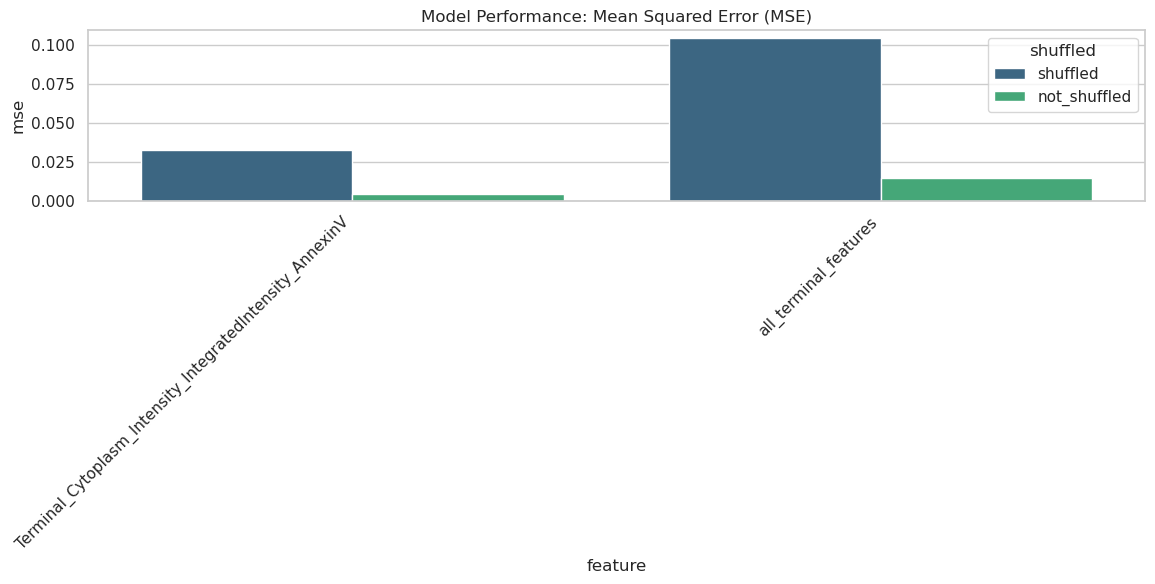

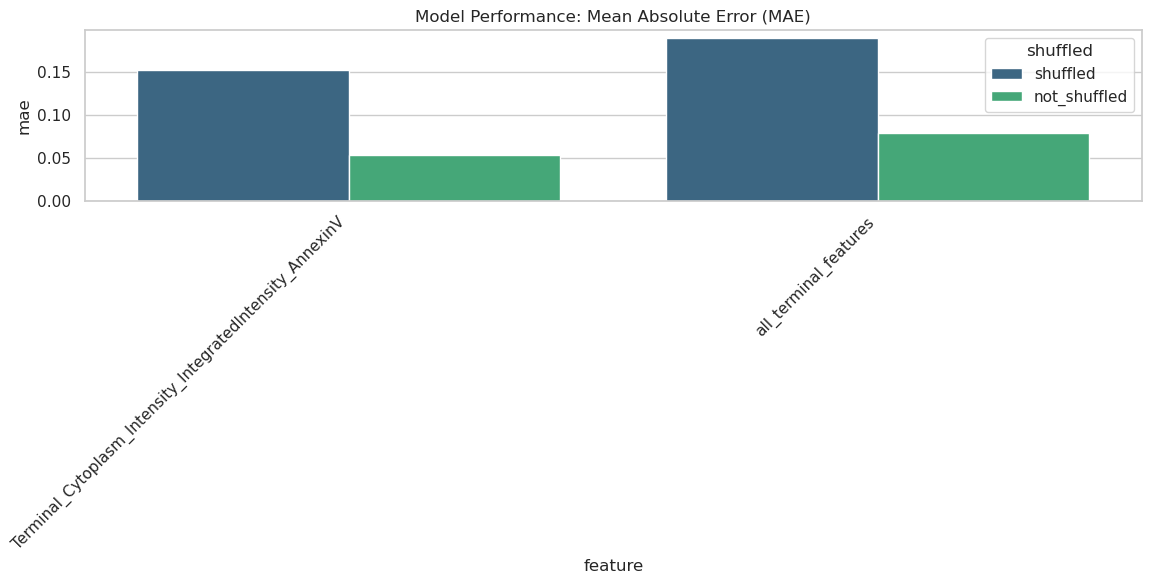

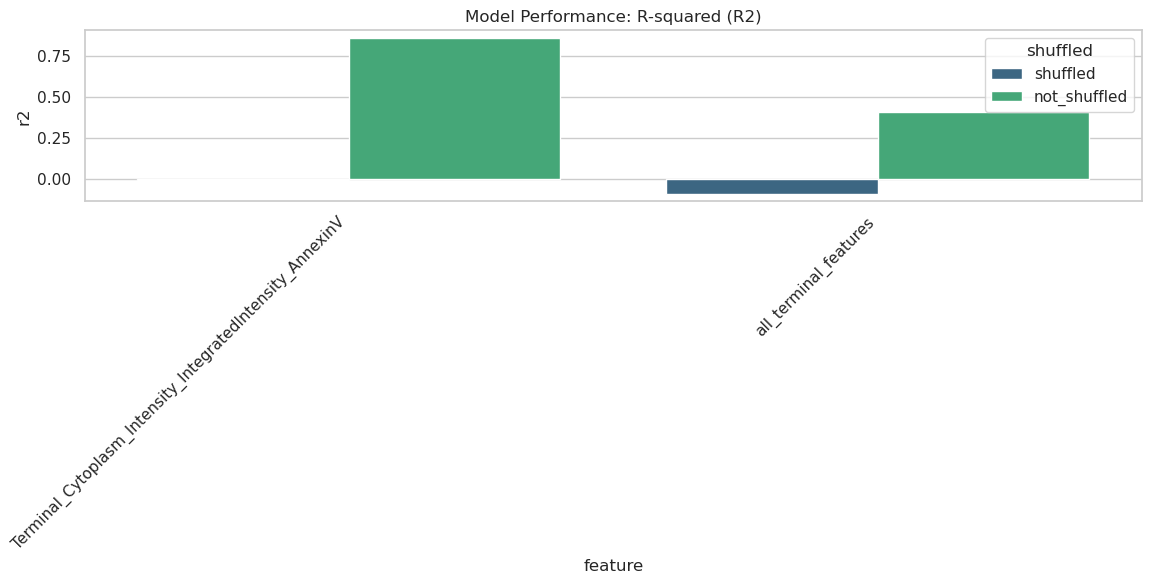

In [11]:
# plot the performance of the models

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x="feature", y="mse", hue="shuffled", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Performance: Mean Squared Error (MSE)")
plt.tight_layout()
plt.figure(figsize=(12, 6))
sns.barplot(x="feature", y="mae", hue="shuffled", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Performance: Mean Absolute Error (MAE)")
plt.tight_layout()
plt.figure(figsize=(12, 6))
sns.barplot(x="feature", y="r2", hue="shuffled", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Performance: R-squared (R2)")
plt.tight_layout()